# Manufacturing Defects EDA

This combination of feature engineering, aggregation, and visualization provided actionable insights to enhance manufacturing operations and optimize resource planning. 

### How This Model Helps with Insights

- Defect Costs: By understanding which defect types and locations incur the highest repair costs, manufacturers can target specific areas for process optimization, such as improving inspection methods or materials used.

- Seasonal Trends: Seasonal trends inform resource allocation, such as scheduling preventive maintenance or quality checks during months with historically high defect rates, reducing downtime and costs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import zipfile
import joblib

In [2]:
# Step 1: Extract Data from Zip File
zip_file_path = 'Manufacturing Defects.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()
    extracted_files = zip_ref.namelist()
    print("Files extracted from Manufacturing Defects.zip:", extracted_files)

# Load the CSV file
csv_file_name = extracted_files[0]  # Assuming single CSV file
df = pd.read_csv(csv_file_name)

# Initial dataset overview
print("\nInitial Dataset Overview:")
print(df.head())
print("\nDataset Info:")
print(df.info())

Files extracted from Manufacturing Defects.zip: ['defects_data.csv']

Initial Dataset Overview:
   defect_id  product_id defect_type defect_date defect_location  severity  \
0          1          15  Structural    6/6/2024       Component     Minor   
1          2           6  Functional   4/26/2024       Component     Minor   
2          3          84  Structural   2/15/2024        Internal     Minor   
3          4          10  Functional   3/28/2024        Internal  Critical   
4          5          14    Cosmetic   4/26/2024       Component     Minor   

   inspection_method  repair_cost  
0  Visual Inspection       245.47  
1  Visual Inspection        26.87  
2  Automated Testing       835.81  
3  Automated Testing       444.47  
4     Manual Testing       823.64  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0 

In [3]:
# Data Cleaning and Preprocessing

# Discovered Seasonal Trends in Defect Occurrences

# Feature Engineering:
# The defect_date column was transformed into defect_year, defect_month, and defect_day, 
# allowing the analysis of defects on a temporal scale.

# Convert 'defect_date' to datetime
df['defect_date'] = pd.to_datetime(df['defect_date'], errors='coerce')

# Check for missing values
print("\nMissing Values Before Cleaning:")
print(df.isnull().sum())

# Fill missing values for numerical columns with median
numerical_columns = ['repair_cost']
for col in numerical_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Fill missing values for categorical columns with mode
categorical_columns = ['defect_type', 'defect_location', 'inspection_method', 'severity']
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Drop rows with missing dates (if critical)
df.dropna(subset=['defect_date'], inplace=True)

# Extract features from 'defect_date'
df['defect_year'] = df['defect_date'].dt.year
df['defect_month'] = df['defect_date'].dt.month
df['defect_day'] = df['defect_date'].dt.day

# Drop the original date column
df.drop(columns=['defect_date'], inplace=True)

# Handle outliers in 'repair_cost' using IQR method
Q1 = df['repair_cost'].quantile(0.25)
Q3 = df['repair_cost'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['repair_cost'] >= lower_bound) & (df['repair_cost'] <= upper_bound)]

# Label encoding for categorical features
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


Missing Values Before Cleaning:
defect_id            0
product_id           0
defect_type          0
defect_date          0
defect_location      0
severity             0
inspection_method    0
repair_cost          0
dtype: int64


C:\Users\milto\AppData\Local\Temp\ipykernel_17568\1613368914.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_17568\1613368914.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa


Dataset Shape After Cleaning: (1000, 10)

Dataset Info After Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   defect_id          1000 non-null   int64  
 1   product_id         1000 non-null   int64  
 2   defect_type        1000 non-null   int32  
 3   defect_location    1000 non-null   int32  
 4   severity           1000 non-null   int32  
 5   inspection_method  1000 non-null   int32  
 6   repair_cost        1000 non-null   float64
 7   defect_year        1000 non-null   int32  
 8   defect_month       1000 non-null   int32  
 9   defect_day         1000 non-null   int32  
dtypes: float64(1), int32(7), int64(2)
memory usage: 50.9 KB
None


C:\Users\milto\AppData\Local\Temp\ipykernel_17568\2619865486.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='severity', palette='viridis')


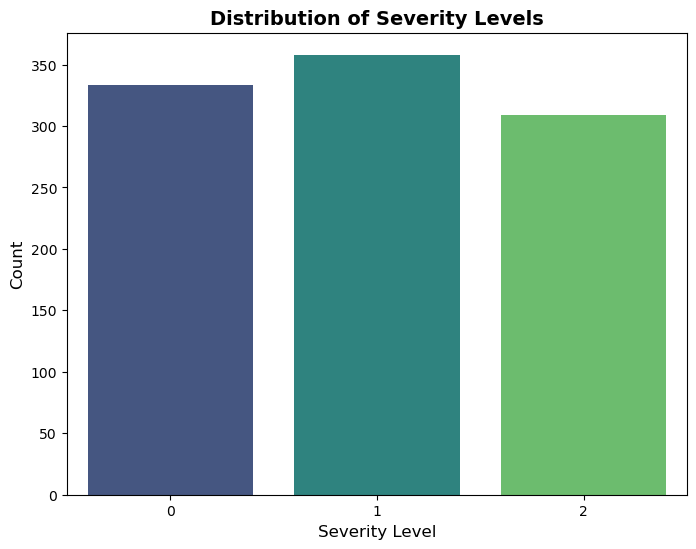

In [4]:
# Exploratory Data Analysis (EDA)
print("\nDataset Shape After Cleaning:", df.shape)
print("\nDataset Info After Cleaning:")
print(df.info())

# Distribution of severity levels
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='severity', palette='viridis')
plt.title('Distribution of Severity Levels', fontsize=14, fontweight='bold')
plt.xlabel('Severity Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_17568\97935674.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='defect_type', y='repair_cost', hue='defect_location', ci=None)


<Axes: xlabel='defect_type', ylabel='repair_cost'>

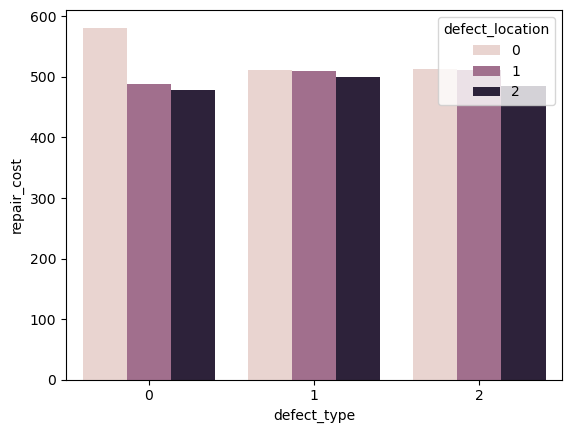

In [9]:
# Identified Defect Types and Locations Contributing to High Repair Costs

repair_cost_summary = df.groupby(['defect_type', 'defect_location'])['repair_cost'].mean().reset_index()
sns.barplot(data=df, x='defect_type', y='repair_cost', hue='defect_location', ci=None)

<Axes: xlabel='defect_month'>

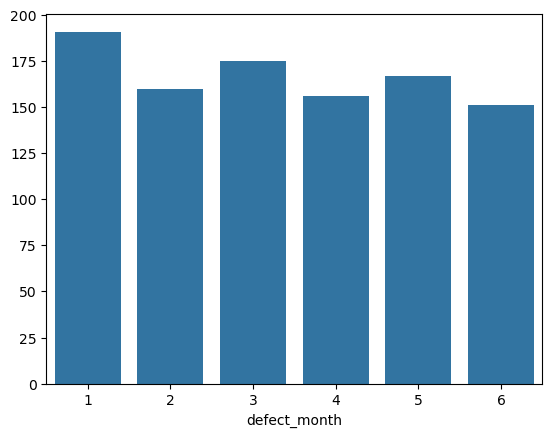

In [11]:
# Discovered Seasonal Trends in Defect Occurrences

# Trend Analysis:
# Defect occurrences were grouped by month to identify seasonal patterns in defect counts

monthly_counts = df.groupby('defect_month').size()
sns.barplot(x=monthly_counts.index, y=monthly_counts.values)

In [5]:
# Data Splitting and Balancing
X = df.drop(columns=['severity'])
y = df['severity']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Address class imbalance with SMOTE
print("Class Distribution Before SMOTE:", y_train.value_counts())
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Class Distribution After SMOTE:", pd.Series(y_train_balanced).value_counts())

# Standardize numerical features
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

Class Distribution Before SMOTE: severity
1    286
0    267
2    247
Name: count, dtype: int64
Class Distribution After SMOTE: severity
0    286
2    286
1    286
Name: count, dtype: int64


In [6]:
# Model Training and Hyperparameter Tuning
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1_weighted', 
    n_jobs=-1, 
    verbose=1
)
grid_search.fit(X_train_balanced, y_train_balanced)

# Best parameters and evaluation
print("\nBest Parameters from Grid Search:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\milto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:07:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters from Grid Search: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.36      0.35        66
           1       0.33      0.33      0.33        72
           2       0.23      0.21      0.22        62

    accuracy                           0.30       200
   macro avg       0.30      0.30      0.30       200
weighted avg       0.30      0.30      0.30       200



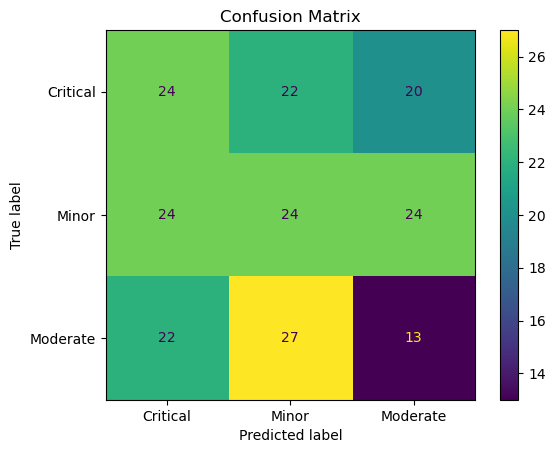

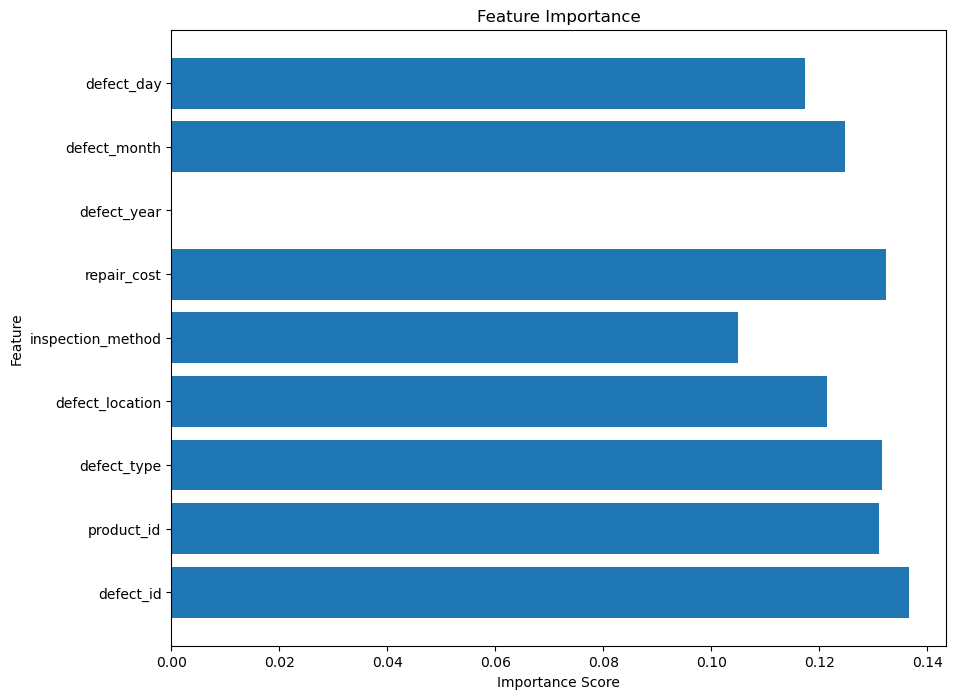

In [7]:
# Save Model and Visualizations
joblib.dump(best_model, 'xgb_best_model.pkl')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoders['severity'].classes_)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
plt.figure(figsize=(10, 8))
plt.barh(X.columns, best_model.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()